In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import time
import utils
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# from google.colab import drive
from torch.utils.data import DataLoader, Dataset

from datetime import datetime

 For GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
learning_rate = 1e-3
batch_size = 6
epochs = 5

In [5]:
class DatasetDiffusionMRI(Dataset):
  def __init__(self, input_file):
    self.df = pd.read_csv(input_file, index_col="ID")

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    features = torch.tensor(self.df.iloc[idx, 2:].to_numpy(copy=True), device=device)
    label = torch.tensor(self.df.iloc[idx, :1].to_numpy(copy=True), device=device)

    #label = label*2 - 1

    return features, label

In [6]:
train_dataset = DatasetDiffusionMRI(train_dataset_path)
test_dataset = DatasetDiffusionMRI(test_dataset_path)

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

Creating my neural network

In [24]:
class NeuralNetwork(nn.Module):
  def __init__(self, in_features: int, hidden_features: int):
    super().__init__()

    self.flatten = nn.Flatten()
    self.activation = nn.ReLU()

    self.fc1 = nn.Linear(
        in_features=in_features,
        out_features=hidden_features,
        dtype=torch.float64
    )
    self.fc2 = nn.Linear(
        in_features=hidden_features,
        out_features=1,
        dtype=torch.float64
    )
    self.tanh = nn.Sigmoid()

  def forward(self, X):
    X = self.flatten(X)
    X = self.activation(self.fc1(X))
    X = self.fc2(X)
    X = self.tanh(X)
    return X


In [25]:
model = NeuralNetwork(len(train_dataset[0][0]), 100).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (fc1): Linear(in_features=727804, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (tanh): Sigmoid()
)


In [26]:
train_dataset[0][0].size()

torch.Size([727804])

In [ ]:
class ModelTrainer():
    def __init__(self, dataset, network, device, metrics, optimizer):
        self.dataset = dataset
        self.network = network.to(device)
        self.device = device
        self.metrics = metrics
        self.optimizer = optimizer

    def __trainOneEpoch(self, epoch_index, tb_writer):
        running_loss = 0

        for i, data in enumerate(training_loader):
            # Step 1: Get the features and the label
            features, labels = data

            # Step 2: Zero the gradient
            optimizer.zero_grad()

            # Step 3: Make predictions
            outputs = model(features)

            # Step 4: Compute the loss
            loss = loss_fn(outputs, labels)

            # - : Compute the gradient
            loss.backward()

            # Step 5: Adjust weights
            optimizer.step()
            
            # Data and report Statistics
            running_loss += loss.item()
            # since the small dataset, report the loss at each batch
            print("\tbatch {} loss: {}".format(i+1, running_loss))
            tb_x = epoch_index*len(training_loader) + i + 1
            tb_writer.add_scalar("Loss/Train", running_loss, tb_x)

        return running_loss/(i+1)
    

    def train(self, epochs):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
        epoch_number = 0 # must be an attribute of the class

        EPOCHS = epochs

        best_vloss = 1_000_000

        for epoch in range(EPOCHS):
            print("EPOCH {}".format(epoch_number + 1))

            # Set the model to training mode
            model.train(True)
            avg_loss = self.__trainOneEpoch(epoch_number, writer)

            # Set the model to validation mode
            running_vloss = 0.0
            model.eval()

            with torch.no_grad():
                for i, vdata in enumerate(validation_loader):
                    # Get the features and the labels
                    features, labels = vdata

                    voutputs = model(features)

                    loss = loss_fn(voutputs, labels)
                    running_vloss +=loss

            avg_vloss = running_vloss/(i+1)
            print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

            # Data and report Statistics
            writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
            writer.flush()

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = "model_{}_{}".format(timestamp, epoch_number)
                torch.save(model.state_dict(), model_path)

            epoch_number += 1



Starting epoch 0
0
1
Epoch 0 loss is 8.333333333333332 \ 10.0
Validating ...

-Ending epoch 0: elapsed time 4.580673694610596 seconds

Starting epoch 1
0
1
Epoch 1 loss is 8.333333333333332 \ 10.0
Validating ...

-Ending epoch 1: elapsed time 4.456449031829834 seconds

Starting epoch 2
0
1
Epoch 2 loss is 8.333333333333332 \ 10.0
Validating ...

-Ending epoch 2: elapsed time 4.500579118728638 seconds

Starting epoch 3
0
1
Epoch 3 loss is 12.5 \ 10.0
Validating ...

-Ending epoch 3: elapsed time 4.53973650932312 seconds

Starting epoch 4
0
1
Epoch 4 loss is 8.333333333333332 \ 10.0
Validating ...

-Ending epoch 4: elapsed time 4.717021465301514 seconds

Testing...
Average test loss: 66.66666666666691


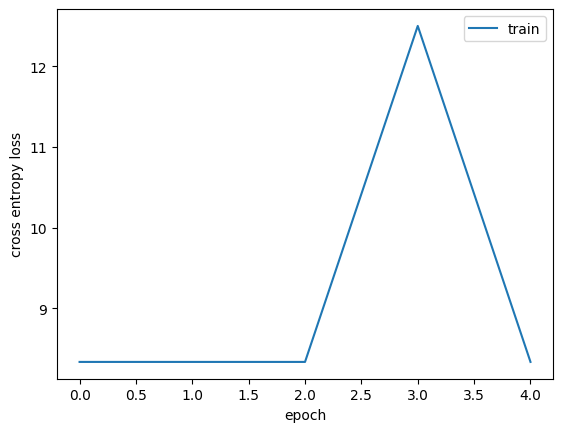

In [28]:
def train_and_test_a_model():
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.BCELoss()

  avg_train_losses = []

  for epoch in range(epochs):
    print(f"Starting epoch {epoch}")
    start = time.time()

    tot_loss, tot_samples = 0.0, 0

    model.train()

    current_train_losses = [] # keep track of all the losses
    for i, batch in enumerate(train_loader):
      print(i)

      # Step 1: retrieving a batch of input from the dataloader
      features, labels = batch
      
      tot_samples += features.size(0)

      # Step 2: zeroin the parameter gradient
      # Always do this before doing loss.backward() !!
      optimizer.zero_grad()

      # Step 3: forward (prediction)
      predictions = model(features)

      # Step 4: compute the loss
      loss = criterion(predictions, labels)
      current_train_losses.append(loss.item())
      tot_loss += loss.data * features.size(0)

      # Step 5: compute the gradient from the loss
      loss.backward()

      # Step 6: Upgrade the model parameters
      optimizer.step()

    avg_train_losses.append(np.mean(current_train_losses))
    print(f"Epoch {epoch} loss is {avg_train_losses[-1]} \ {tot_loss*1.0/float(tot_samples)}")

    end = time.time()

    print("Validating ...")
    # Validation

    print(f"\n-Ending epoch {epoch}: elapsed time {end - start} seconds\n")

  # Test the model on unseen data
  print("Testing...")
  test_losses = []
  with torch.no_grad():
    model.eval()
    for batch in test_loader:
      # Step 1: retrieving batch of input from dataloader
      features, labels = batch
      features, labels = features.to(device), labels.to(device)

      # Step 2: prediction
      predictions = model(features)

      test_losses.append(criterion(predictions, labels).item())
  print(f"Average test loss: {np.mean(test_losses)}")

  plt.plot(avg_train_losses, label='train')
  # plt.plot(avg_val_losses, label='val')
  plt.xlabel('epoch')
  plt.ylabel('cross entropy loss')
  plt.legend()
  torch.save(model, f'trained_model_{epoch}.pth')
  return model


model = train_and_test_a_model()